In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 
from delta_kernal import *

In [2]:
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599
syn= sd.Catalog_scene(ra,dec,120,Maglim= 18, Sector=23, Catalog='unified',Interpolate=False,Plot=True)#,Save='PS1_catalog_scene.pdf')
sources = syn['sources']
tpf = syn['tpf']
cat = syn['catalog']

SearchError: Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI.Error: 400 Client Error: Bad Request: Cutout area exceeds area limit of 10,000 pixels for url: https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=189.1385827&dec=11.2316599&y=120&x=120&units=px&sector=23

In [206]:
bkg_l = sd.Scene_bkg_estimate(sources,tpf,Limit=.3,interp_method='linear')
#bkg_c = sd.Scene_bkg_estimate(sources,tpf,Limit=.3,interp_method='cubic')
#bkg_n = sd.Scene_bkg_estimate(sources,tpf,Limit=.3,interp_method='nearest')

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../scenes/syndiff.py:633: RuntimeWarning: invalid value encountered in less
  large = masked < (med + sigma*std)[:,np.newaxis,np.newaxis]


<IPython.core.display.Javascript object>


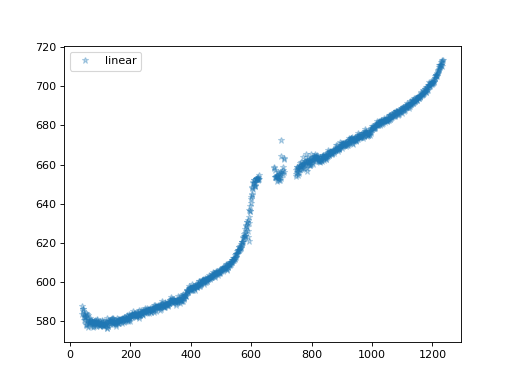

In [208]:
f = tpf.flux.copy()
f[f==0] = np.nan
plt.figure()
#plt.plot(f[:,50,50] - bkg_c[:,50,50],'.',alpha=0.3,label='cubic')
#plt.plot(f[:,50,50] - bkg_n[:,50,50],'+',alpha=0.3,label='nearest')
plt.plot(f[:,60,60] - bkg_l[:,60,60]+50,'*',alpha=0.3,label='linear')
plt.legend()

In [6]:
#f_c = f - bkg_c
#f_n = f - bkg_n
f_l = f - bkg_l

#lc_c = np.nansum(f_c[:,50:52,50:51],axis=(1,2))
#lc_c[lc_c==0] = np.nan

#lc_n = np.nansum(f_n[:,50:52,49:51],axis=(1,2))
#lc_n[lc_n==0] = np.nan

lc_l = np.nansum(f_l[:,50:52,49:51],axis=(1,2))
lc_l[lc_l==0] = np.nan

<IPython.core.display.Javascript object>


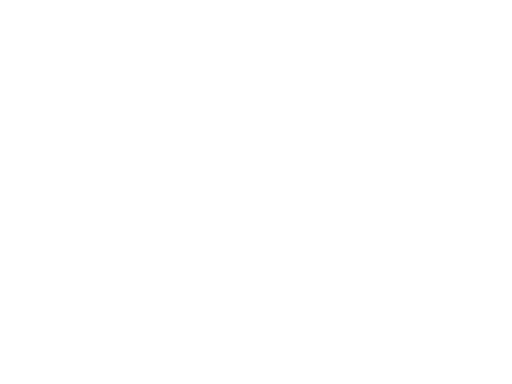

In [206]:
plt.figure()
#plt.plot(lc_c,'.')
plt.plot(lc_l,'.')

<IPython.core.display.Javascript object>


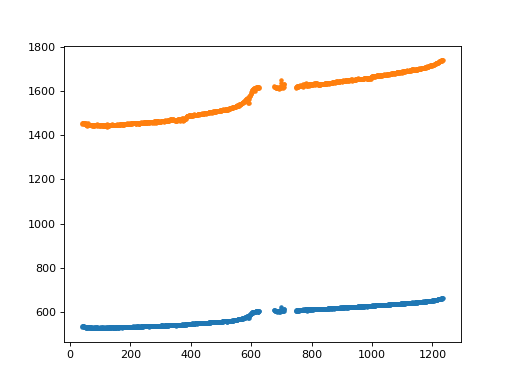

In [148]:
plt.figure()
#plt.plot(f_l[:,50,49],'.')
plt.plot(f_l[:,50,50],'.')
plt.plot(f_l[:,51,50]+f_l[:,50,50],'.')
#plt.plot(f_l[:,50,51],'.')
#plt.plot(f_l[:,51,51],'.')

<IPython.core.display.Javascript object>


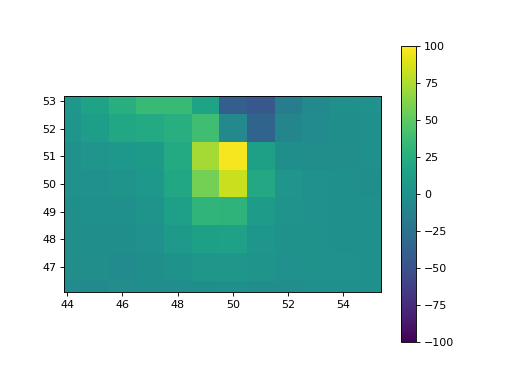

In [37]:
plt.figure()
plt.imshow(f_c[1000]-f_c[400],origin='',vmin = -100,vmax =100)
plt.colorbar()

In [361]:
f = tpf.flux - new_bkg
#f = f_l.copy()
#f[f<0] = 0
b = bkg_l.copy()
b[b==0] = np.nan
b = b[:500]
me = np.nanmedian(b,axis=0)
ind = np.where(np.nansum(b < me,axis=(1,2)) > (b.shape[1]*2))[0]
low_bkg_flux = f_l[ind]
#low_bkg_flux[low_bkg_flux==0] = np.nan
median = np.nanmedian(low_bkg_flux,axis=0)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [210]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

In [362]:
def Smooth_motion(Centroids,tpf):
    split = np.where(np.diff(tpf.astropy_time.mjd) > 1)[0][0] + 1
    smoothed = np.zeros_like(Centroids) * np.nan
    # ugly, but who cares
    ind1 = np.nansum(tpf.flux[:split],axis=(1,2))
    ind1 = np.where(ind1 != 0)[0]
    ind2 = np.nansum(tpf.flux[split:],axis=(1,2))
    ind2 = np.where(ind2 != 0)[0] + split
    smoothed[ind1,0] = savgol_filter(Centroids[ind1,0],51,3)
    smoothed[ind2,0] = savgol_filter(Centroids[ind2,0],51,3)

    smoothed[ind1,1] = savgol_filter(Centroids[ind1,1],51,3)
    smoothed[ind2,1] = savgol_filter(Centroids[ind2,1],51,3)
    return smoothed
    

In [363]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)

m = median.copy()
mean, med, std = sigma_clipped_stats(m, sigma=3.0)
s = daofind(m - med)
mx = s['xcentroid']
my = s['ycentroid']
shifts = np.zeros((len(tpf.flux),2,len(mx))) * np.nan
for i in range(len(f)):
    if np.nansum(f[i]) > 0:
        mean, med, std = sigma_clipped_stats(f[i], sigma=3.0)
        s = daofind(f[i] - med)
        x = s['xcentroid']
        y = s['ycentroid']
        dist = np.zeros((len(mx),len(x)))
        dist = dist + np.sqrt((x[np.newaxis,:] - mx[:,np.newaxis])**2 + (y[np.newaxis,:] - my[:,np.newaxis])**2)

        ind = np.argmin(dist,axis=1)
        indo = np.nanmin(dist) < 1
        ind = ind[indo]
        shifts[i,0,indo] = x[ind] - mx[indo]
        shifts[i,1,indo] = y[ind] - my[indo]

        
meds = np.nanmedian(shifts,axis = 2)
smooth = Smooth_motion(meds,tpf)
nans = np.nansum(f_l,axis=(1,2)) ==0
smooth[nans] = np.nan        

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


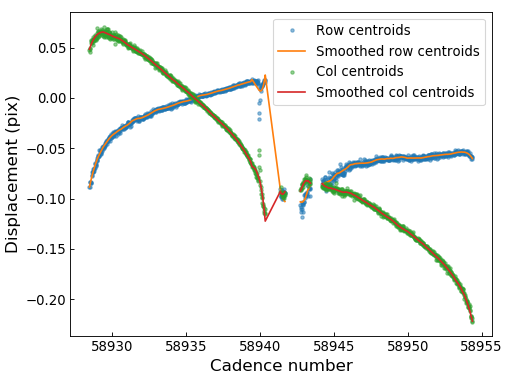

In [364]:
t = tpf.astropy_time.mjd
plt.figure()
plt.plot(t,meds[:,0],'.',label='Row centroids',alpha =0.5)
plt.plot(t,smooth[:,0],'-',label='Smoothed row centroids')
plt.plot(t,meds[:,1],'.',label='Col centroids',alpha =0.5)
plt.plot(t,smooth[:,1],'-',label='Smoothed col centroids')
#plt.plot(thing,'+')
plt.ylabel('Displacement (pix)',fontsize=15)
plt.xlabel('Cadence number',fontsize=15)
plt.legend(fontsize=12)
plt.gca().tick_params(which='both',direction='in')
plt.tight_layout()
plt.tick_params(axis='both', labelsize=12)
plt.savefig('2020fqv_motion.pdf')

In [365]:
def Shift_median(Offset,Med):
    """
    Shifts data by the values given in offset. Breaks horribly if data is all 0.

    """
    Offset[np.isnan(Offset)] = 0
    shifted = np.zeros((len(Offset),Med.shape[0],Med.shape[1]))
    Med[np.isnan(Med)] = 0
    Med[Med<0] = 0
    for i in range(len(Offset)):
        shifted[i] = sd.shift(Med,[Offset[i,1],Offset[i,0]],mode='nearest',order=3)

    return shifted

In [366]:
m = median.copy()
stest = Shift_median(smooth,m)

subtract = f- stest
#mmm_s = Shift_images(smooth,mmm)
subtract[subtract==0] = np.nan

<IPython.core.display.Javascript object>


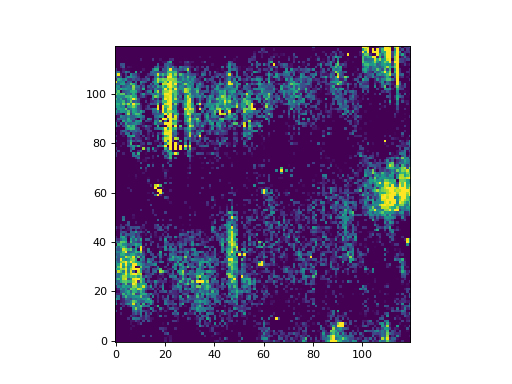

In [367]:
plt.figure()
plt.imshow(subtract[700],vmin = 0,vmax = 40,origin='')

<IPython.core.display.Javascript object>


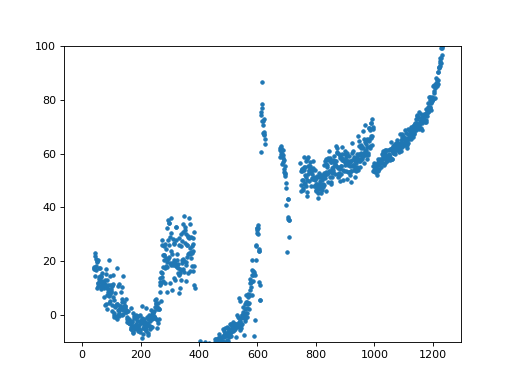

(-10, 100)

In [375]:
#lc = np.nansum(subtract[:,60:61,60:61],axis=(1,2))
lc = subtract[:,68,67]
#lc[lc==0] = np.nan
med = np.nanmedian(lc[:500])
plt.figure()
plt.plot(lc-med,'.')
plt.ylim(-10,100)

<IPython.core.display.Javascript object>


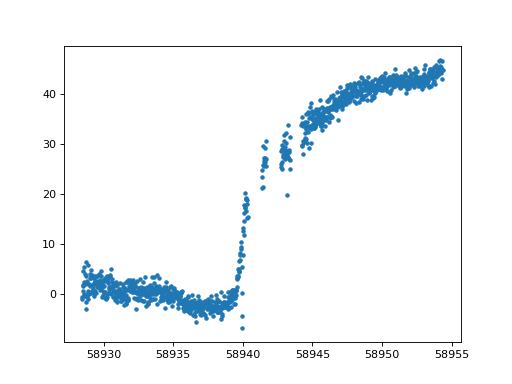

In [388]:
lc = np.nansum(subtract[:,59:62,60:62],axis=(1,2))
lc = subtract[:,60,60] - subtract[:,64,60]
lc[lc>=60] = np.nan
med = np.nanmedian(lc[:500])
plt.figure()
plt.plot(t,lc-med,'.')
#plt.ylim(-10,50)

<IPython.core.display.Javascript object>


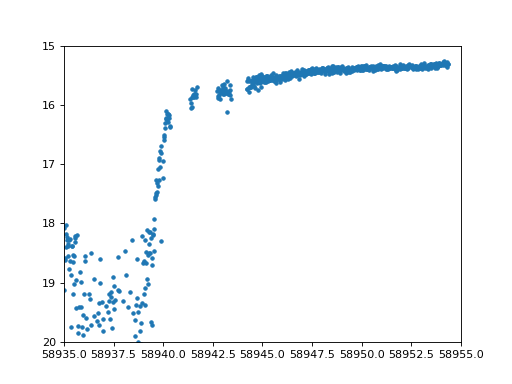

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


(58935, 58955)

In [389]:
lc = np.nansum(subtract[:,59:62,60:62],axis=(1,2))
lc = subtract[:,60,60] - subtract[:,64,60]
lc[lc > 60] = np.nan
#lc[lc==0] = np.nan
med = np.nanmedian(lc[:500])
plt.figure()
plt.plot(t,-2.5*np.log10(lc-med+2.8)+19.5,'.')
plt.ylim(20,15)
plt.xlim(58935,58955)

<IPython.core.display.Javascript object>


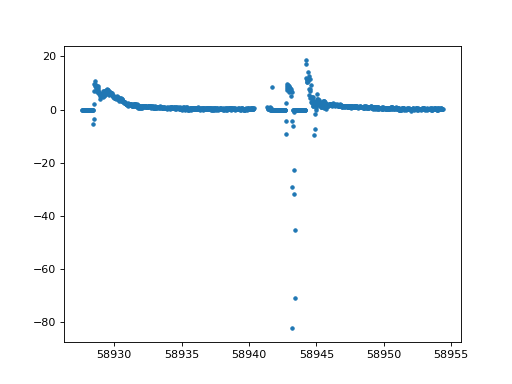

In [406]:
plt.figure()
plt.plot(t,new_bkg[:,80,68]-new_bkg[:,80,60],'.')


In [391]:
saver.shape

(2, 1235)

In [392]:
np.save('20fqv_strip_bkg',saver)

../scenes/utils.py:108: RuntimeWarning: invalid value encountered in greater
  bads = np.nansum(lc>1.2)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]


<IPython.core.display.Javascript object>


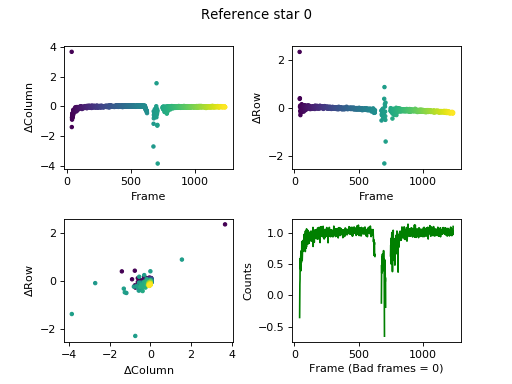

../scenes/utils.py:143: RuntimeWarning: invalid value encountered in greater
  bads = np.nansum(lc>1.2)


<IPython.core.display.Javascript object>


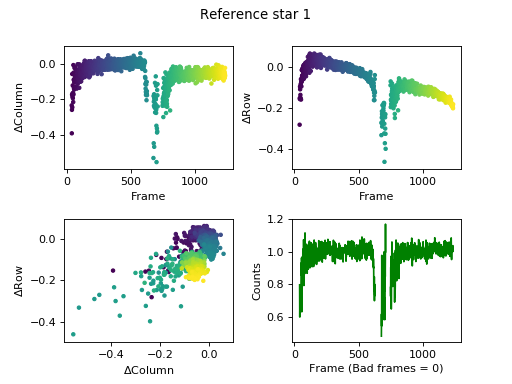

<IPython.core.display.Javascript object>


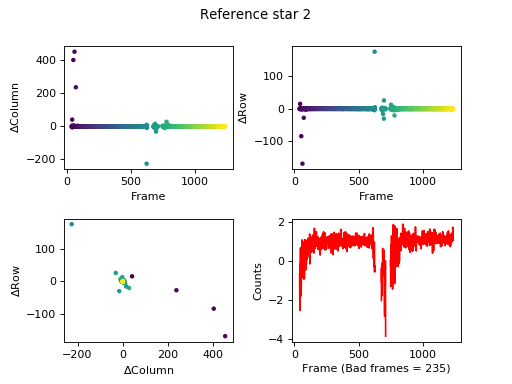

<IPython.core.display.Javascript object>


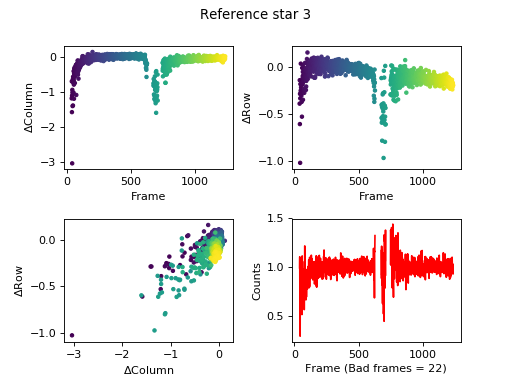

<IPython.core.display.Javascript object>


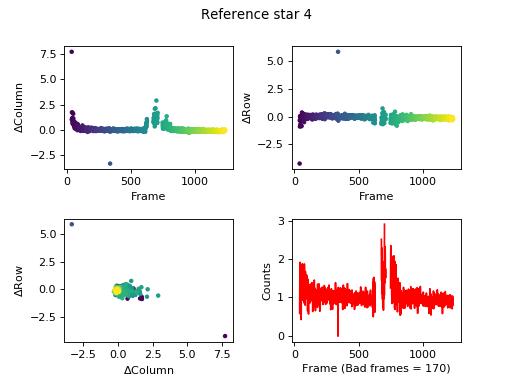

<IPython.core.display.Javascript object>


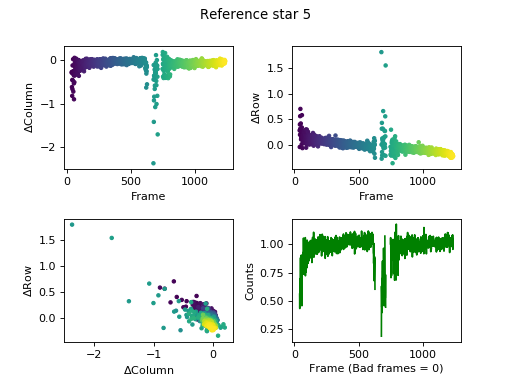

<IPython.core.display.Javascript object>


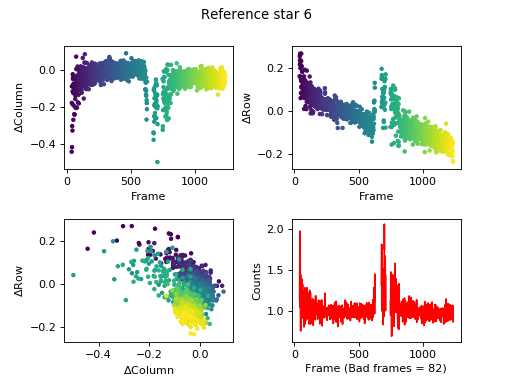

<IPython.core.display.Javascript object>


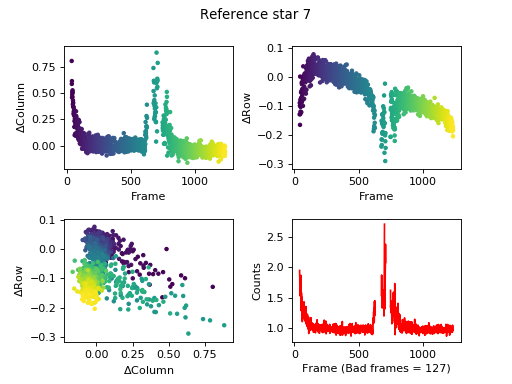

<IPython.core.display.Javascript object>


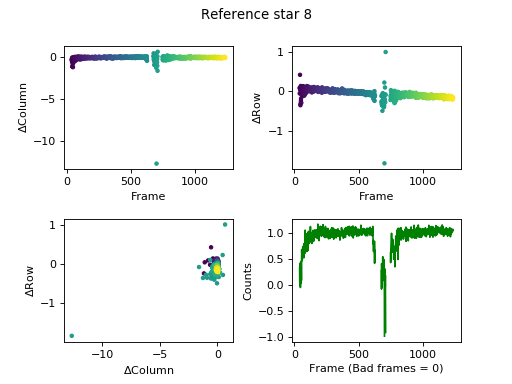

<IPython.core.display.Javascript object>


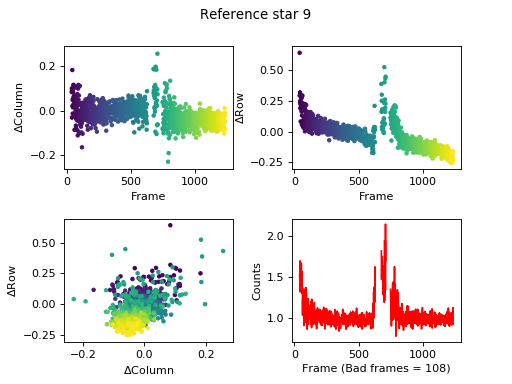

<IPython.core.display.Javascript object>


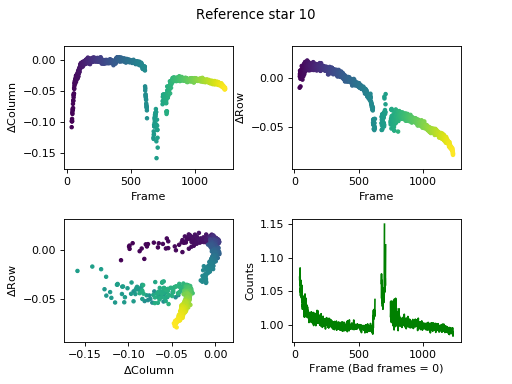

<IPython.core.display.Javascript object>


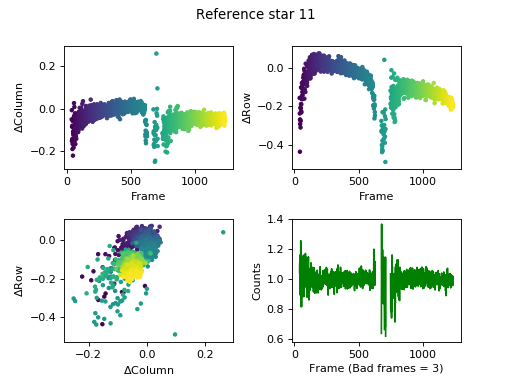

<IPython.core.display.Javascript object>


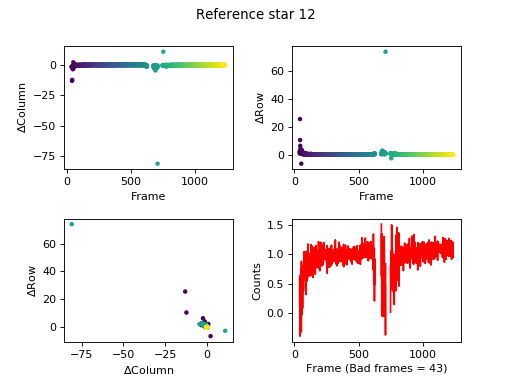

<IPython.core.display.Javascript object>


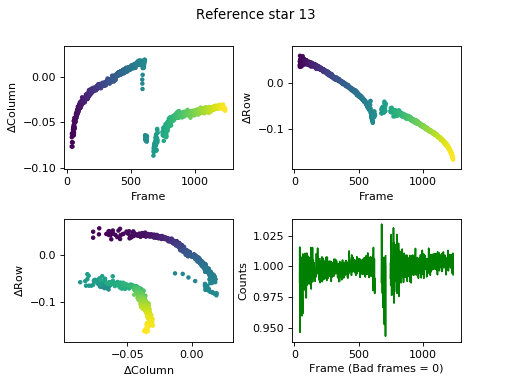

/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


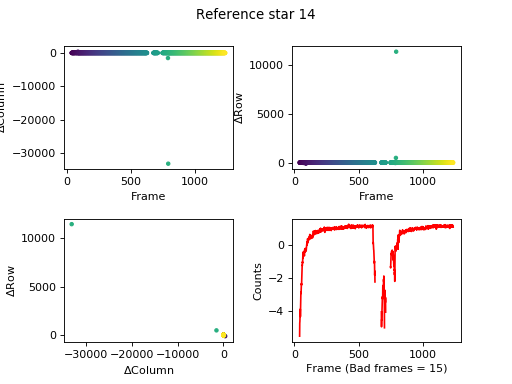

<IPython.core.display.Javascript object>


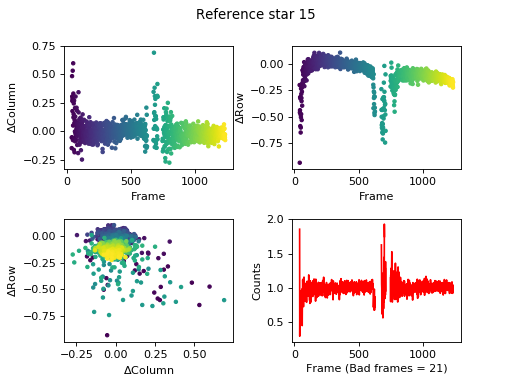

<IPython.core.display.Javascript object>


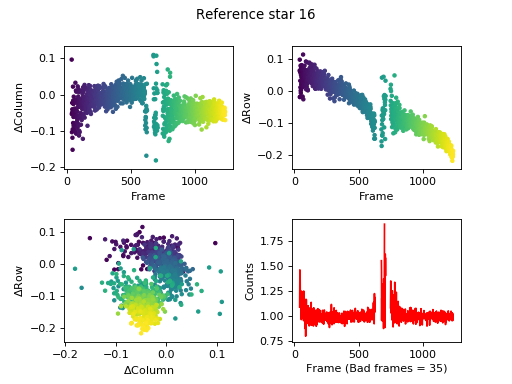

<IPython.core.display.Javascript object>


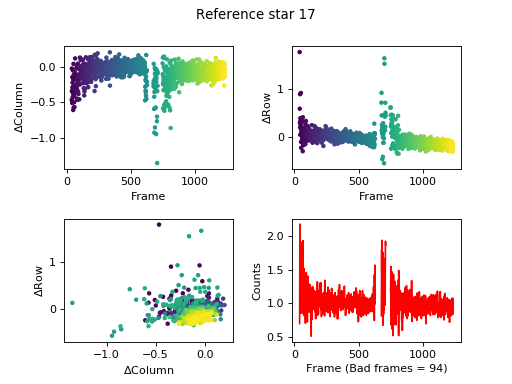

<IPython.core.display.Javascript object>


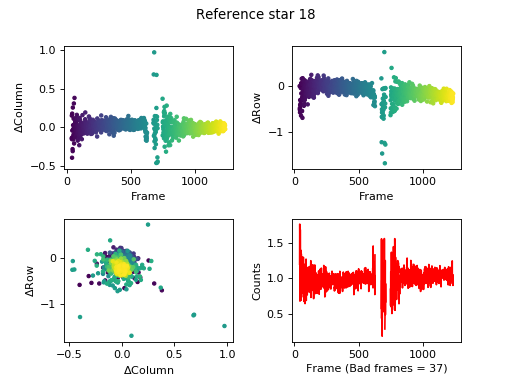

<IPython.core.display.Javascript object>


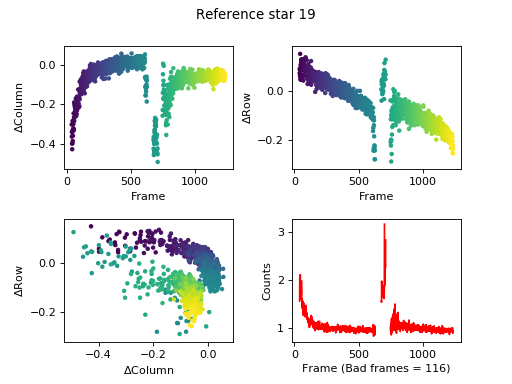

<IPython.core.display.Javascript object>


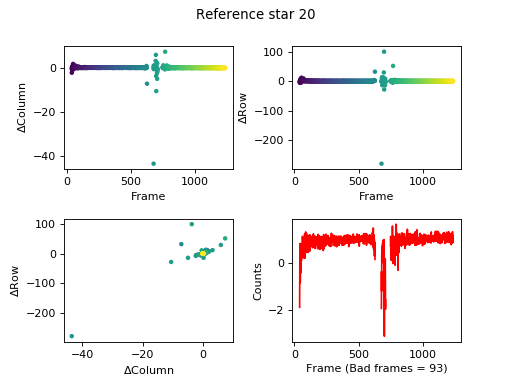

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [58]:
pos = np.array([cat.col.values,cat.row.values]).T
Tmag = cat.tmag.values
loc,iso,ts = sd.Isolated_stars(pos,Tmag,f,median,sources,Mag=16,Distance=7)
c, flag = sd.Centroids(ts,iso[:,1],1,True)
medc = np.nanmedian(c,axis=0)

In [9]:
def Smooth_motion(Centroids,tpf):
    split = np.where(np.diff(tpf.astropy_time.mjd) > 1)[0][0] + 1
    smoothed = np.zeros_like(Centroids) * np.nan
    # ugly, but who cares
    ind1 = np.nansum(tpf.flux[:split],axis=(1,2))
    ind1 = np.where(ind1 != 0)[0]
    ind2 = np.nansum(tpf.flux[split:],axis=(1,2))
    ind2 = np.where(ind2 != 0)[0] + split
    smoothed[ind1,0] = savgol_filter(Centroids[ind1,0],51,3)
    smoothed[ind2,0] = savgol_filter(Centroids[ind2,0],51,3)

    smoothed[ind1,1] = savgol_filter(Centroids[ind1,1],51,3)
    smoothed[ind2,1] = savgol_filter(Centroids[ind2,1],51,3)
    return smoothed
    

<IPython.core.display.Javascript object>


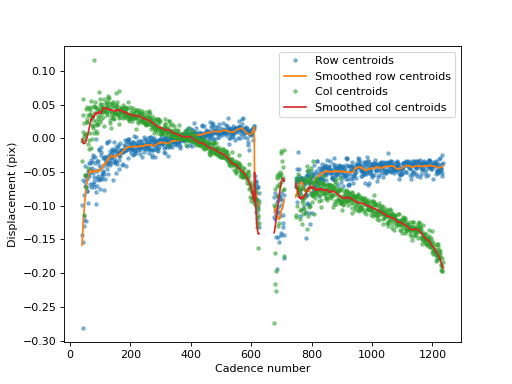

In [62]:
plt.figure()
plt.plot(meds[:,0],'.',label='Row centroids',alpha =0.5)
plt.plot(smooth[:,0],'-',label='Smoothed row centroids')
plt.plot(meds[:,1],'.',label='Col centroids',alpha =0.5)
plt.plot(smooth[:,1],'-',label='Smoothed col centroids')
#plt.plot(thing,'+')
plt.ylabel('Displacement (pix)',fontsize=15)
plt.xlabel('Cadence number',fontsize=15)
plt.legend(fontsize=12)
plt.gca().tick_params(which='both',direction='in')
plt.tight_layout()
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('2020fqv_motion.pdf')

In [10]:
def Shift_median(Offset,Med):
    """
    Shifts data by the values given in offset. Breaks horribly if data is all 0.

    """
    Offset[np.isnan(Offset)] = 0
    shifted = np.zeros((len(Offset),Med.shape[0],Med.shape[1]))
    Med[np.isnan(Med)] = 0
    Med[Med<0] = 0
    for i in range(len(Offset)):
        shifted[i] = sd.shift(Med,[Offset[i,1],Offset[i,0]],mode='nearest',order=3)

    return shifted

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [-0.06424335, -0.23554448],
       [-0.06466921, -0.23713067],
       [-0.06511215, -0.23876319]])

In [17]:
m = median.copy()
stest = Shift_median(smooth,m)

mmm = f - stest
#mmm_s = Shift_images(smooth,mmm)
mmm[f==0] = np.nan
#mmm_s[f==0] = np.nan
ff= f.copy()
ff[f==0] = np.nan
ff = ff - median

IndexError: tuple index out of range

In [1]:
lc = np.nansum(mmm[:,50:51,50:51]+50,axis=(1,2))
lc[lc==0] = np.nan
med = np.nanmedian(lc[:500])

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


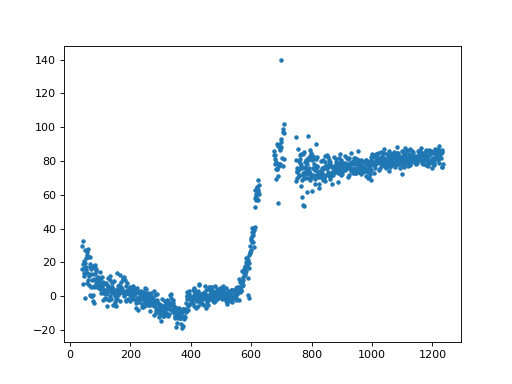

In [143]:
plt.figure()
plt.plot(lc-med,'.')

Current shifts are no good

In [11]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

m = median.copy()
mean, med, std = sigma_clipped_stats(m, sigma=3.0)
s = daofind(m - med)
mx = s['xcentroid']
my = s['ycentroid']
shifts = np.zeros((len(tpf.flux),2,len(mx))) * np.nan
for i in range(len(f)):
    if np.nansum(f[i]) > 0:
        mean, med, std = sigma_clipped_stats(f[i], sigma=3.0)
        s = daofind(f[i] - median)
        x = s['xcentroid']
        y = s['ycentroid']
        dist = np.zeros((len(mx),len(x)))
        dist = dist + np.sqrt((x[np.newaxis,:] - mx[:,np.newaxis])**2 + (y[np.newaxis,:] - my[:,np.newaxis])**2)

        ind = np.argmin(dist,axis=1)
        indo = np.nanmin(dist) < 1
        ind = ind[indo]
        shifts[i,0,indo] = x[ind] - mx[indo]
        shifts[i,1,indo] = y[ind] - my[indo]

        
meds = np.nanmedian(shifts,axis = 2)
smooth = Smooth_motion(meds,tpf)
nans = np.nansum(f_l,axis=(1,2)) ==0
smooth[nans] = np.nan        

In [12]:
mean, median, std = sigma_clipped_stats(f, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)

In [96]:
sources = daofind(f[1000] - median)

In [97]:
x2 = sources['xcentroid']
y2 = sources['ycentroid']

In [98]:
x - x2

ValueError: operands could not be broadcast together with shapes (91,) (88,) 

In [99]:
xx = np.zeros((len(x),len(x2)))
xx = xx + np.sqrt((x[:,np.newaxis] - x2[np.newaxis,:])**2 + (y[:,np.newaxis] - y2[np.newaxis,:])**2)

In [83]:
sources

<Table length=88>
  id      xcentroid      ...        flux                mag         
int64      float64       ...      float64             float64       
----- ------------------ ... ------------------ --------------------
    1  44.68211852195444 ... 1.1109482697945843 -0.11423459229859459
    2  55.09191610955357 ...  16.12314687089051   -3.018624525323275
    3  84.38816074160513 ...  2.007875914600821  -0.7568421754786636
    4  5.599273440413894 ...  1.158093374247268 -0.15935894227279046
    5   93.1337837854183 ... 3.4512450224689384  -1.3449394832249033
    6  61.79549831686433 ... 1.2807937120769792  -0.2686979669826409
    7 28.548108555813528 ...  4.183554357771006  -1.5538635405868835
    8  71.61494008992672 ...  5.010214128086091  -1.7496407181905516
    9  88.97951680540002 ... 2.1692244644986856  -0.8407612344030903
   10   68.0846980910931 ...  9.728298734856963   -2.470092245926684
  ...                ... ...                ...                  ...
   79  58.28281592046985 ...  1.091244185626604 -0.09480485677373576
   80 10.654774924422135 ... 1.0332425585498222 -0.03550571540121119
   81  93.74287657471476 ... 3.0899591564410036   -1.224881847227519
   82  19.26498788621409 ... 1.0681208107004732  -0.0715509417811396
   83  78.14724078887755 ... 2.2014814780797303  -0.8567875898061384
   84  8.428506737136882 ...  2.023333457159913  -0.7651686573352795
   85  50.20818530712977 ...  5.259514286737377  -1.8023640978702504
   86  78.01790764114779 ... 1.4963037887880446  -0.4375494390356796
   87 35.623899160266994 ...  4.716766778799511  -1.6841110075612222
   88  41.02259509707035 ... 1.3206697838732389 -0.30198560389775436

In [104]:
xx.shape

(91, 88)

In [105]:
np.nanmin(xx[0,:])

0.1374261079794138

In [118]:
sum(np.nanmin(xx,axis=1) < 1)

88

In [120]:
shifts = np.zeros((len(tpf.flux),2)) * np.nan

In [121]:
shifts.shape

(1235, 2)

In [14]:
m = median.copy()
mean, med, std = sigma_clipped_stats(m, sigma=3.0)
s = daofind(m - med)
mx = s['xcentroid']
my = s['ycentroid']
shifts = np.zeros((len(tpf.flux),2,len(mx))) * np.nan
for i in range(len(f)):
    if np.nansum(f[i]) > 0:
        mean, med, std = sigma_clipped_stats(f[i], sigma=3.0)
        s = daofind(f[i] - median)
        x = s['xcentroid']
        y = s['ycentroid']
        dist = np.zeros((len(mx),len(x)))
        dist = dist + np.sqrt((x[np.newaxis,:] - mx[:,np.newaxis])**2 + (y[np.newaxis,:] - my[:,np.newaxis])**2)

        ind = np.argmin(dist,axis=1)
        indo = np.nanmin(dist) < 1
        ind = ind[indo]
        shifts[i,0,indo] = x[ind] - mx[indo]
        shifts[i,1,indo] = y[ind] - my[indo]

        
meds = np.nanmedian(shifts,axis = 2)
smooth = Smooth_motion(meds,tpf)
nans = np.nansum(f_l,axis=(1,2)) ==0
smooth[nans] = np.nan        

In [117]:
meds = np.nanmedian(shifts,axis = 2)
smooth = Smooth_motion(meds,tpf)
nans = np.nansum(f_l,axis=(1,2)) ==0
smooth[nans] = np.nan

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


<IPython.core.display.Javascript object>


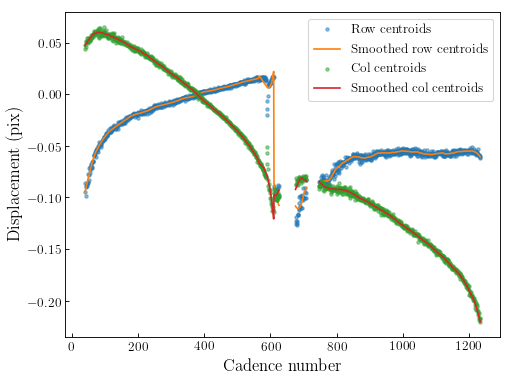

In [119]:
plt.figure()
plt.plot(meds[:,0],'.',label='Row centroids',alpha =0.5)
plt.plot(smooth[:,0],'-',label='Smoothed row centroids')
plt.plot(meds[:,1],'.',label='Col centroids',alpha =0.5)
plt.plot(smooth[:,1],'-',label='Smoothed col centroids')
#plt.plot(thing,'+')
plt.ylabel('Displacement (pix)',fontsize=15)
plt.xlabel('Cadence number',fontsize=15)
plt.legend(fontsize=12)
plt.gca().tick_params(which='both',direction='in')
plt.tight_layout()
plt.tick_params(axis='both', labelsize=12)
plt.savefig('2020fqv_motion.pdf')

In [19]:
median

0.0

In [38]:
median = np.nanmedian(low_bkg_flux,axis=0)
median = np.nanmedian(f_l[:500],axis=0)
m = median.copy()
stest = Shift_median(smooth,m)

In [106]:
from photutils import CircularAperture
p = np.transpose((x, y))
ap = CircularAperture(p, r=4.)
p2 = np.transpose((x2, y2))
ap2 = CircularAperture(p2, r=4.)

<IPython.core.display.Javascript object>


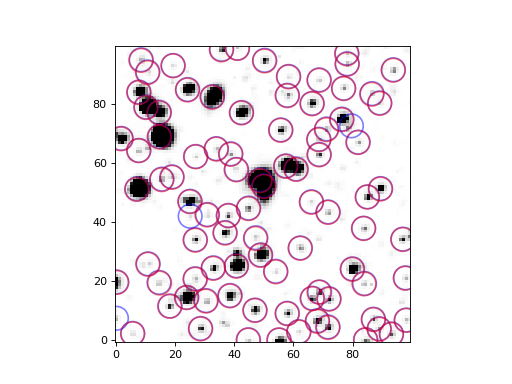

In [107]:
plt.figure()
plt.imshow(m, cmap='Greys', origin='lower',vmax = 100)
ap.plot(color='blue', lw=1.5, alpha=0.5)
ap2.plot(color='red', lw=1.5, alpha=0.5)

<IPython.core.display.Javascript object>


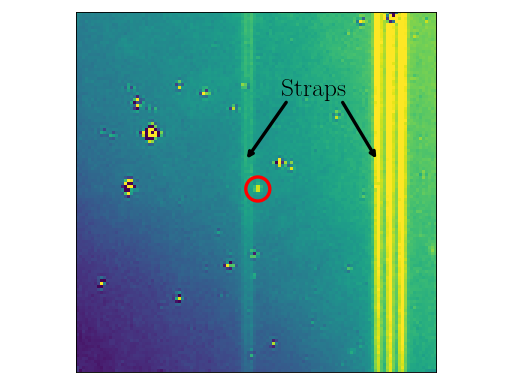

In [442]:
plt.figure()
plt.imshow(tpf.flux[800]-stest[800],origin='',vmin=900,vmax=1000)
#plt.plot(50,50,'k*')
#plt.ylabel('Row')
#plt.xlabel('Col')

plt.gca().add_artist(plt.Circle((60.1, 60.5), 4, color='r',lw=3, fill=False))
plt.Circle((0, 0), 2, color='r')
plt.text(60+8,91,'Straps',fontsize=23,color='k')
plt.annotate('',(90+10,70),(78+10,90),
             arrowprops=dict(arrowstyle="->",color='black',lw=3))
plt.annotate('',(46+10, 70), (60+10, 90), 
             arrowprops=dict(arrowstyle="->", color='k',lw=3))
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.savefig('2020fqv_straps.pdf')

<IPython.core.display.Javascript object>


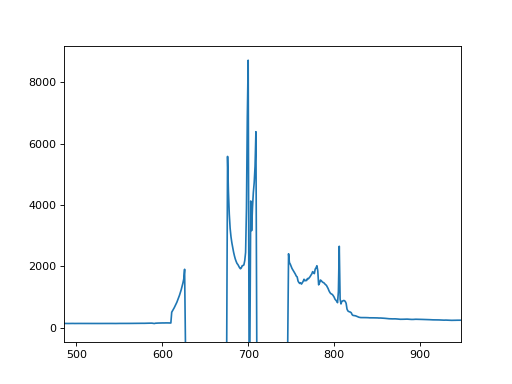

In [117]:
i = 50
j = 50
plt.figure()
plt.plot(tpf.flux[:,i,j]-stest[:,i,j])
#plt.ylim(0,60)

<IPython.core.display.Javascript object>


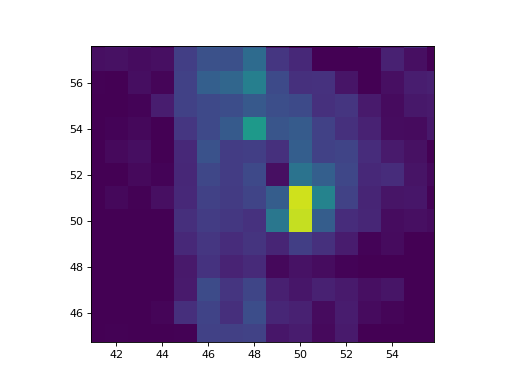

In [113]:
plt.figure()
plt.imshow(tpf.flux[800]-stest[800] - bkg_l[800],vmin=0,vmax=50,origin='')

<IPython.core.display.Javascript object>


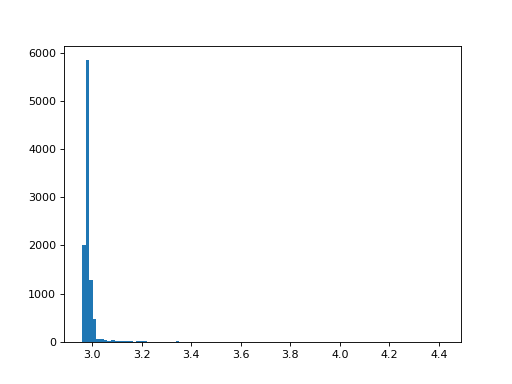

(array([2.020e+03, 5.850e+03, 1.274e+03, 4.780e+02, 6.600e+01, 5.300e+01,
        3.800e+01, 2.000e+01, 2.800e+01, 1.700e+01, 1.800e+01, 1.300e+01,
        1.200e+01, 9.000e+00, 5.000e+00, 1.100e+01, 1.000e+01, 7.000e+00,
        5.000e+00, 3.000e+00, 5.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        5.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

In [56]:
plt.figure()
plt.hist(np.log10(tpf.flux[800]).flatten(),bins=100)

# Try secondary background

assume that the median subtraction is pretty much perfect, so all residuals are background. Mask out the transient pixels and interpolate over them.

In [139]:
bkg2 = tpf.flux - stest
#bkg2[:,49:52,49:52] = np.nan

<IPython.core.display.Javascript object>


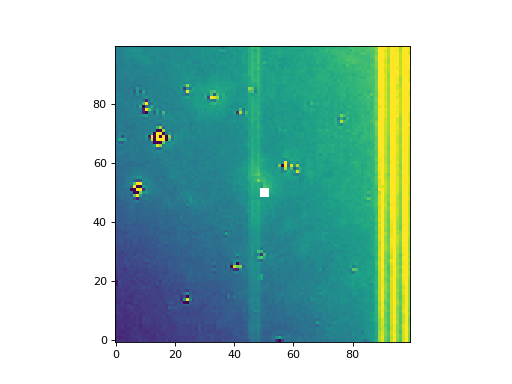

In [123]:
plt.figure()
plt.imshow(bkg2[800],vmin=900,vmax=1000,origin='')

Interpolate over masked area

In [134]:
from scipy import interpolate
from tqdm.notebook import tqdm

In [ ]:
tqdm()

In [135]:
b = np.zeros_like(tpf.flux)
x = np.arange(0, bkg2.shape[2])
y = np.arange(0, bkg2.shape[1])
#mask invalid values
for i in tqdm(range(len(bkg2))):
    arr = bkg2[i].copy()
    arr = np.ma.masked_invalid(arr)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~arr.mask]
    y1 = yy[~arr.mask]
    newarr = arr[~arr.mask]

    estimate = interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy),method='linear')
    b[i] = estimate

<IPython.core.display.Javascript object>


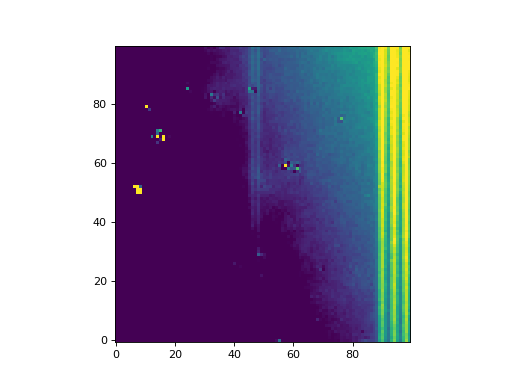

In [136]:
plt.figure()
plt.imshow(b[80],vmin=900,vmax=1000,origin='')

In [40]:
stand = (f_l - stest)[:,50,52]

<IPython.core.display.Javascript object>


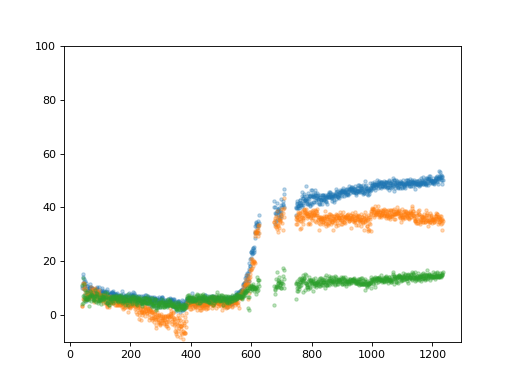

(-10, 100)

In [41]:
plt.figure()
plt.plot((f_l - stest)[:,50,50]-stand,'.',alpha =0.3)
plt.plot((f_l - stest)[:,51,50]-stand - 9,'.',alpha =0.3)
#plt.plot((f_l - stest)[:,51,51]-stand-5,'.',alpha =0.3)
plt.plot((f_l - stest)[:,50,51]-stand,'.',alpha =0.3)
#plt.plot((f_l - stest)[:,50,52],'.')
#plt.plot((bkg_l)[:,50,51]-137,'.')
plt.ylim(-10,100)

In [128]:
thingo =(f_l - stest)[:,20,50] + (f_l - stest)[:,21,50] - 2*stand -6
basic = (f_l - stest)[:,20,50]-stand
raw = f_l[:,20,50]- median[20,50]-stand

In [407]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<IPython.core.display.Javascript object>


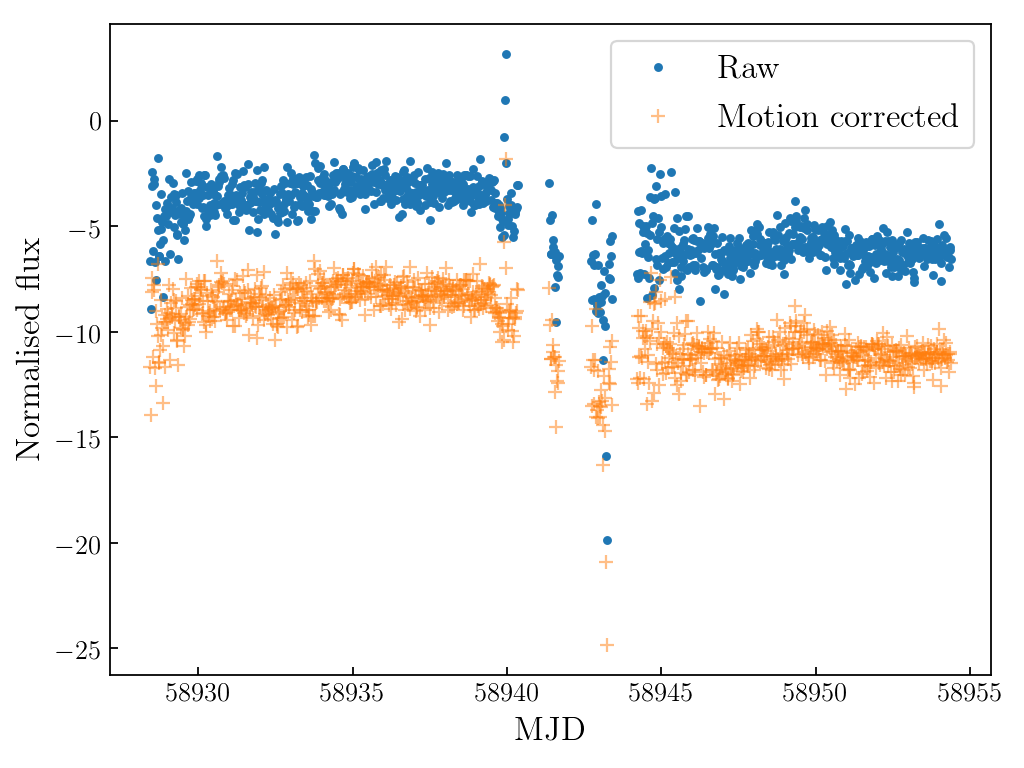

In [129]:
plt.figure()
plt.plot(tpf.astropy_time.mjd,raw,'.',alpha =1,label='Raw')
plt.plot(tpf.astropy_time.mjd,basic-5,'+',alpha =.5,label='Motion corrected')
plt.legend(fontsize=15)
plt.ylabel('Normalised flux',fontsize=15)
plt.xlabel('MJD',fontsize=15)
plt.gca().tick_params(which='both',direction='in')
plt.tight_layout()
plt.tick_params(axis='both', labelsize=12)
#plt.savefig('20fqv_raw_corrected.pdf')
#plt.plot(thingo/np.nanmedian(thingo),'.',alpha =0.3)


In [199]:
np.save('2020fqv_single_pix',[tpf.astropy_time.mjd,basic])

In [67]:
syn = np.nansum(sources,axis=0)
f = tpf.flux

In [68]:
mask = (syn < 1) * 1.0

<IPython.core.display.Javascript object>


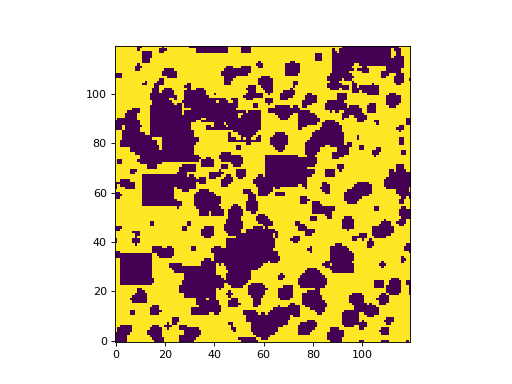

<IPython.core.display.Javascript object>


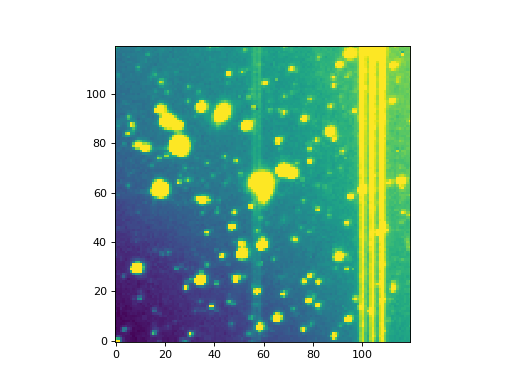

In [69]:
plt.figure()
plt.imshow(mask,origin='')

plt.figure()
plt.imshow(f[800],origin='',vmax=1000)

In [130]:
mask[mask == 0] = np.nan
masked = f*mask

<IPython.core.display.Javascript object>


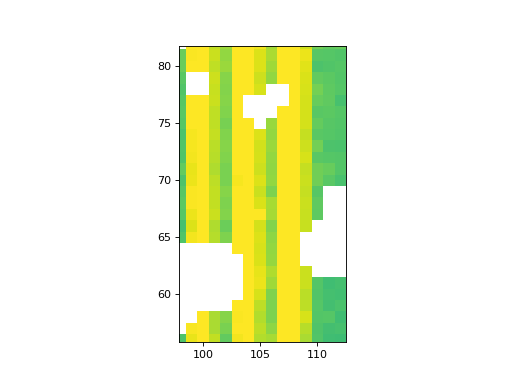

In [71]:
plt.figure()
plt.imshow(masked[800],origin='',vmax=1000)

<IPython.core.display.Javascript object>


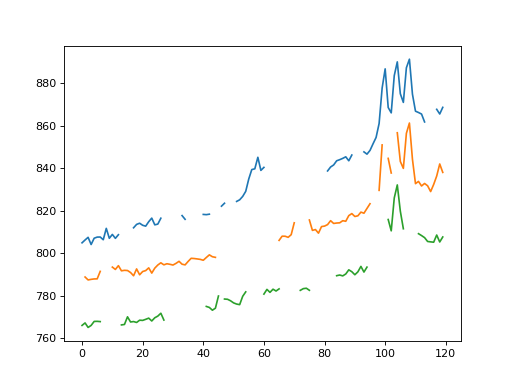

In [72]:
plt.figure()
plt.plot(masked[810,71,:])
#plt.plot(bkg_l[800,66,:],'--')
#plt.plot(masked[800,63,:])
#plt.plot(bkg_l[800,63,:],'--')
plt.plot(masked[810,41,:])
plt.plot(masked[810,18,:])
#plt.plot(bkg_l[800,18,:],'--')

<IPython.core.display.Javascript object>


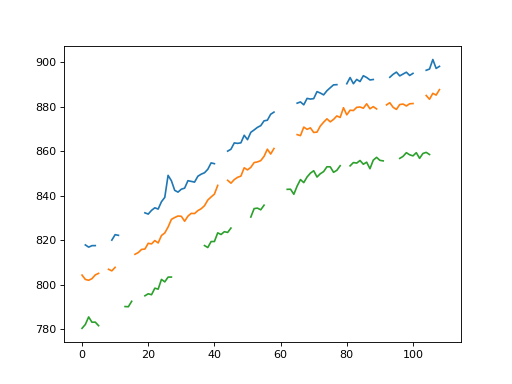

In [80]:
plt.figure()
plt.plot(masked[810,:,100])
plt.plot(masked[810,:,101])
plt.plot(masked[810,:,95])

In [81]:
masked.shape

(1235, 120, 120)

In [83]:
x.min

<function ndarray.min>

In [99]:
regressionLineOrder = 4
regressionLine = np.polyfit(x[finite], y[finite], regressionLineOrder)
p = np.poly1d(regressionLine)

<IPython.core.display.Javascript object>


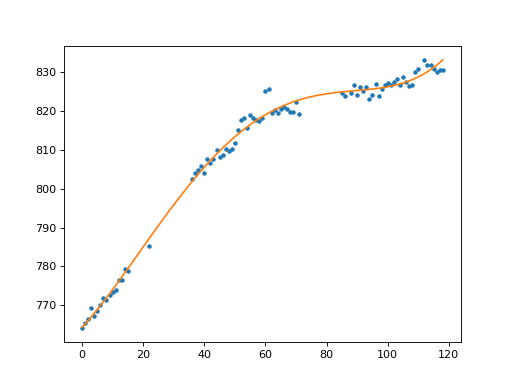

In [104]:
from scipy.interpolate import CubicSpline
x = np.arange(0,masked.shape[1])
y = masked[811,:,10]
finite = np.isfinite(y)
regressionLine = np.polyfit(x[finite], y[finite], regressionLineOrder)
p = np.poly1d(regressionLine)
x_range = np.arange(x.min(), x.max(), 1)
plt.figure()
plt.plot(x,y,'.')
plt.plot(x_range, p(x_range), label='Cubic Spline')

In [216]:
import sys
sys.path.append('../../Sigma_clip/')
import sigmacut

def sigma_mask(data,error= None,sigma=3,Verbose= False):
    if type(error) == type(None):
        error = np.zeros(len(data))
    
    calcaverage = sigmacut.calcaverageclass()
    calcaverage.calcaverage_sigmacutloop(data,Nsigma=sigma
                                         ,median_firstiteration=True,saveused=True)
    if Verbose:
        print("mean:%f (uncertainty:%f)" % (calcaverage.mean,calcaverage.mean_err))
    return calcaverage.clipped

In [ ]:
def Sig_clip_frames(tpf,mask,sigma=3,itters=5):
    masks = np.zeros_like(tpf.flux) + mask[np.newaxis,:,:]
    
    for i in range(itters):
        masked = tpf.flux * masks
        masked[masked==0] = np.nan
        med = np.nanmedian(masked,axis=(1,2))
        std = np.nanstd(masked,axis=(1,2))
        
        large = masked < (med + sigma*std)[:,np.newaxis,np.newaxis]
        masks = masks * large
        

In [221]:
syn

{'catalog':                     objID     RAJ2000    DEJ2000  e_RAJ2000  e_DEJ2000  \
 974    120931891603447983  189.160154  10.781219     0.1877     0.0726   
 2101   120861893191514290  189.319070  10.719806     0.0045     0.0046   
 2217   120881892631788785  189.263114  10.740215     0.0273     0.0064   
 2277   120921893157184918  189.315675  10.770316     0.0032     0.0021   
 2319   120921893833692961  189.383320  10.768723     0.0192     0.0157   
 ...                   ...         ...        ...        ...        ...   
 20648  122071889031119809  188.903089  11.732794     0.0024     0.0028   
 20657  122061888989109963  188.898945  11.724568     0.0033     0.0026   
 22123                 NaN  188.988297  11.404921        NaN        NaN   
 22124                 NaN  188.988927  11.405107        NaN        NaN   
 22128                 NaN  188.850284  11.497687        NaN        NaN   
 
           gmag  e_gmag    gKmag  e_gKmag     rmag  ...    yKmag  e_yKmag  \
 974    17

In [310]:
fake = np.nansum(sources,axis=0)
mask = (fake < 1) * 1.0
mask = sd.Sig_clip_frames(tpf,mask)
mask[:,54:70,50:66] = 0

mask[mask == 0] = np.nan
masked = tpf.flux*mask

<IPython.core.display.Javascript object>


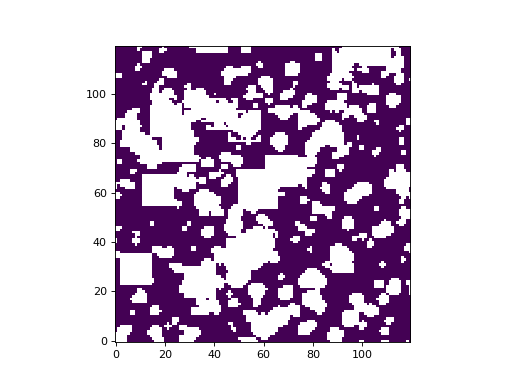

In [311]:
plt.figure()
plt.imshow(mask[700],origin='')

<IPython.core.display.Javascript object>


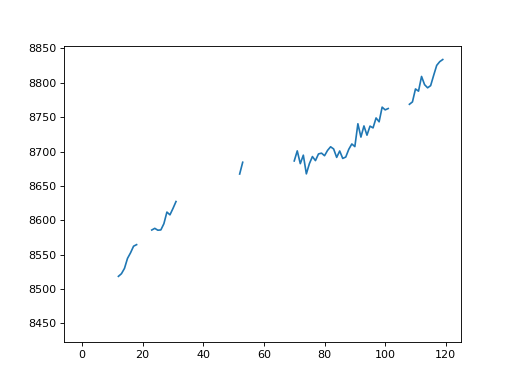

In [309]:
plt.figure()
plt.plot(masked[700,:,60])

In [360]:
mask[mask == 0] = np.nan
masked = tpf.flux*mask

new_bkg = np.zeros_like(masked)
for i in range(masked.shape[0]):
    for j in range(masked.shape[2]):
        x = np.arange(0,masked.shape[2])
        y = masked[i,:,j].copy()
        finite = np.isfinite(y)
        if len(y[finite]) > 5:
            bad = sigma_mask(y[finite],sigma=3)
            finite = np.where(finite)[0]
            y[finite[bad]] = np.nan
            finite = np.isfinite(y)
            regressionLine = np.polyfit(x[finite], y[finite], 3)
            p = np.poly1d(regressionLine)
            
            thingo = y - p(x)
            finite = np.isfinite(thingo)
            bad = sigma_mask(thingo[finite],sigma=2)
            finite = np.where(finite)[0]
            y[finite[bad]] = np.nan
            finite = np.isfinite(y)
            regressionLine = np.polyfit(x[finite], y[finite], 3)
            p = np.poly1d(regressionLine)
            new_bkg[i,:,j] = p(x)
            


<IPython.core.display.Javascript object>


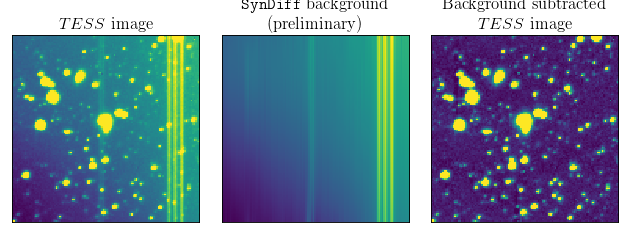

In [475]:
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.title('$TESS$ image',fontsize=15)
plt.imshow(tpf.flux[800],origin='',vmin=np.nanmin(new_bkg[800]),vmax=np.nanmax(new_bkg[800]))
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

plt.subplot(1,3,2)
string = r'\texttt{SynDiff} background'
string += "\n(preliminary)"
plt.title(string,fontsize=15)
plt.imshow(new_bkg[800],origin='')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

plt.subplot(1,3,3)
plt.title('Background subtracted \n$TESS$ image',fontsize=15)
plt.imshow(f[800],origin='',vmin = np.percentile(f[699],20),vmax = 50)
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()

plt.savefig('backg_sub.pdf', bbox_inches="tight")

<IPython.core.display.Javascript object>


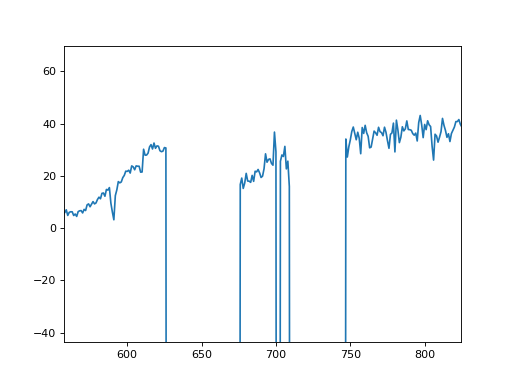

In [247]:
plt.figure()
test = subtract - new_bkg
plt.plot(test[:,60,60])

<IPython.core.display.Javascript object>


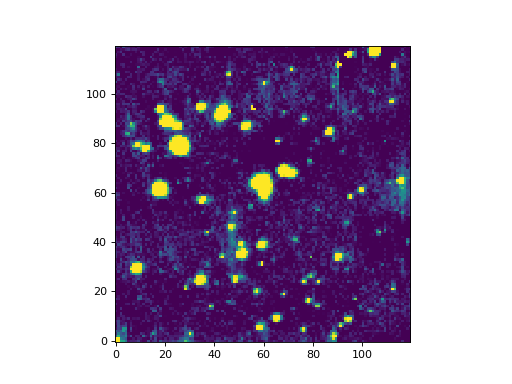

<IPython.core.display.Javascript object>


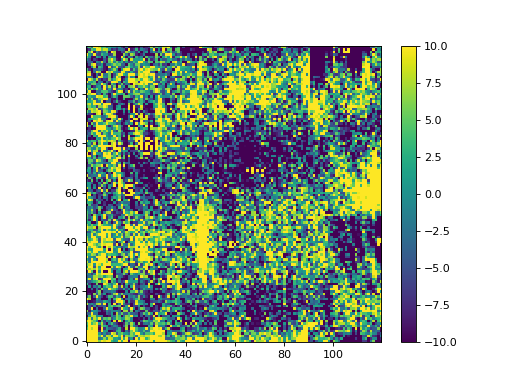

In [244]:
plt.figure()
plt.imshow(tpf.flux[700] - new_bkg[700],origin='',vmin=0,vmax=100)

plt.figure()
plt.imshow(subtract[700] - new_bkg[700],origin='',vmin=-10,vmax=10)
plt.colorbar()

In [245]:
lc = np.nansum(test[:,59-3:62-3,58:62],axis=(1,2))
#lc = np.nansum((tpf.flux-new_bkg)[:,59:62,58:62],axis=(1,2))

<IPython.core.display.Javascript object>


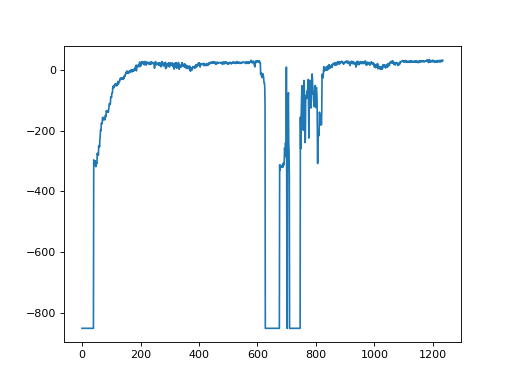

In [246]:
plt.figure()
plt.plot(lc)
#plt.ylim(0,300)

<IPython.core.display.Javascript object>


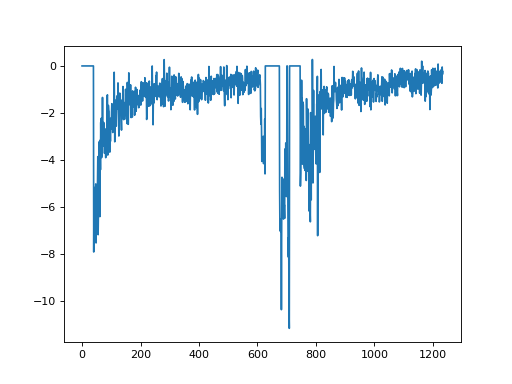

In [189]:
plt.figure()
plt.plot(test[:,42,87])

<IPython.core.display.Javascript object>


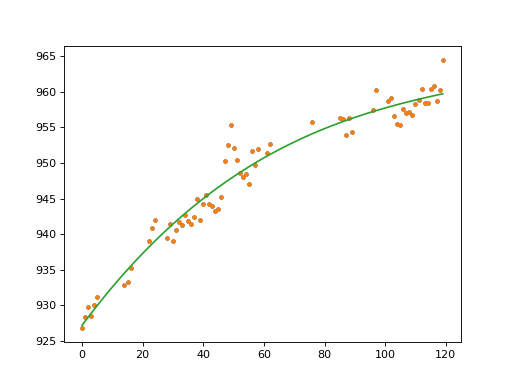

In [376]:
x = np.arange(0,masked.shape[1])
y = masked[800,:,67].copy()
yy = masked[800,:,67].copy()
finite = np.isfinite(y)
bad = sigma_mask(y[finite],sigma=3)
finite = np.where(finite)[0]
y[finite[bad]] = np.nan
finite = np.isfinite(y)
regressionLine = np.polyfit(x[finite], y[finite], 3)
p = np.poly1d(regressionLine)
x_range = np.arange(x.min(), x.max(), 1)
plt.figure()
plt.plot(x,yy,'.')
plt.plot(x,y,'.')
plt.plot(x, p(x), label='Cubic Spline')

<IPython.core.display.Javascript object>


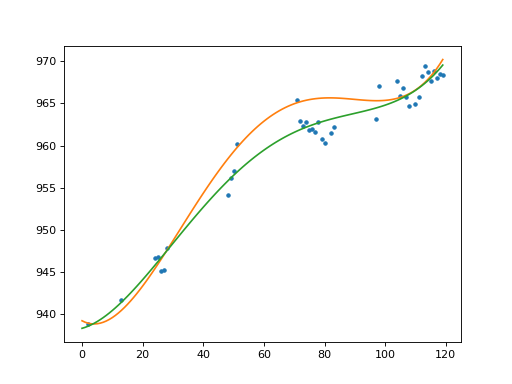

In [241]:

thingo = y - p(x)
finite = np.isfinite(thingo)
bad = sigma_mask(thingo[finite],sigma=2)
finite = np.where(finite)[0]
y[finite[bad]] = np.nan
finite = np.isfinite(y)
regressionLine = np.polyfit(x[finite], y[finite], 4)
p = np.poly1d(regressionLine)
x_range = np.arange(x.min(), x.max(), 1)
plt.figure()
plt.plot(x,y,'.')
plt.plot(x, p1(x), label='Cubic Spline')
plt.plot(x, p(x), label='Cubic Spline')

<IPython.core.display.Javascript object>


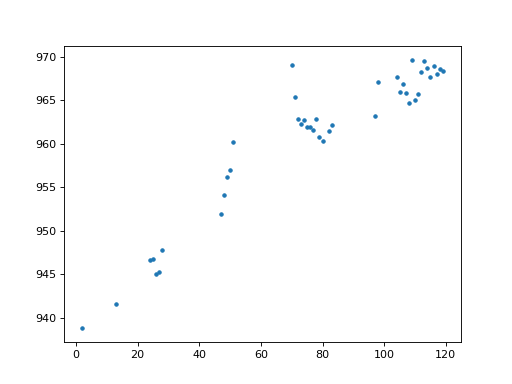

In [233]:
plt.figure()
plt.plot(x[finite],y[finite],'.')